In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
from scipy.optimize import curve_fit

/eos/home-i02/s/sivander/SWAN_projects/tutorial/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/eos/home-i02/s/sivander/SWAN_projects/tutorial/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### latency scan from the july test beam
Keep in mind these are digis, not tracks, so they're the same type of tree on which you ran your code for the occupancy plots early on. In addition, there you have a branch called "runParameter" which is the latency of each event. 

In [2]:
file = uproot.open("/eos/cms/store/group/upgrade/GEM/TestBeams/July2022/digi/00000387.root")
file.keys()

['outputtree;1']

In [3]:
tree = file["outputtree"]
branches = tree.arrays()
tree.keys()

['nhits',
 'runParameter',
 'pulse_stretch',
 'slot',
 'OH',
 'VFAT',
 'CH',
 'digiChamber',
 'digiEta',
 'digiDirection',
 'digiStrip']

In [4]:
event_num = len(branches["runParameter"])

You will see that the latency changes over the course of the run (you can plot latency vs event number there to get started)

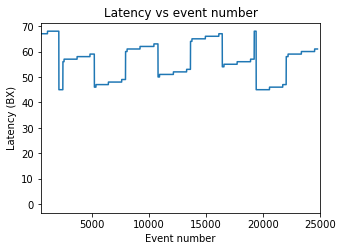

In [5]:
fig, ax = plt.subplots(figsize=(5, 3.5))
events = np.arange(0, event_num, 1)
ax.plot(events, branches["runParameter"])
ax.set(xlabel="Event number", ylabel="Latency (BX)", title="Latency vs event number", xlim=(500, 25000))
plt.savefig("latency_eventnr", dpi=300)
plt.show()

The latency is scanned cyclically between 40 and 70, although I'm not sure why not all the ranges are covered per cycle, it might be the L1A ID resets at some point during the run

What you need to do to analyze this run is group the events by the same latency and then for each slot (slot 0 is ME0, slot 1 is GE2/1), for each OH and each VFAT you need to plot the event multiplicity vs latency. The multiplicity of the event is just the number of strips that fired during that event in the chosen VFAT.

The multiplicity is a number per event per VFAT. Then you need to sum together the multiplicities of all the events with the fixed latency for that VFAT.
At the very end you have a bunch of zeros and ones, and the correct latency is the one that maximizes the total number of ones

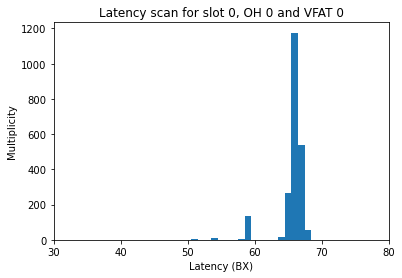

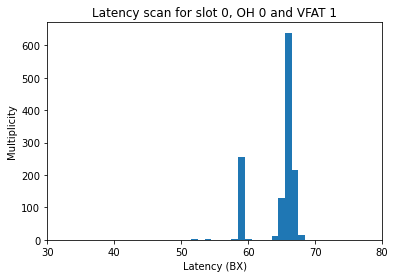

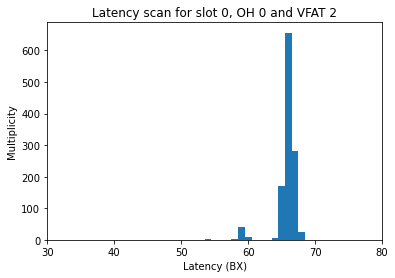

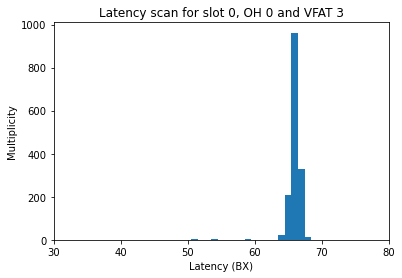

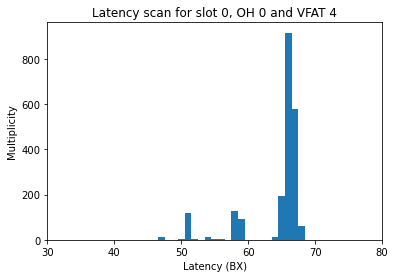

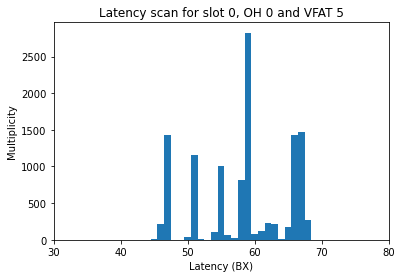

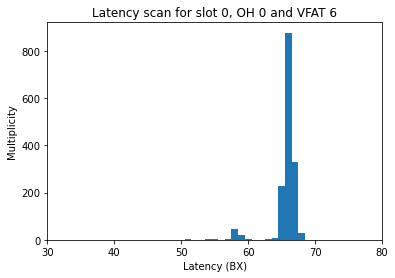

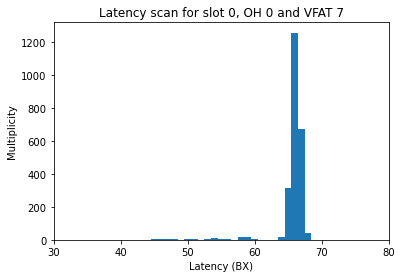

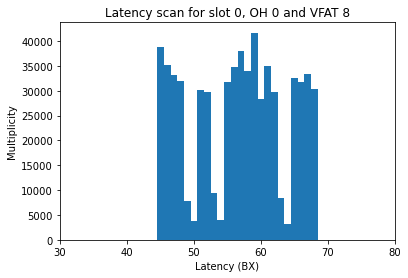

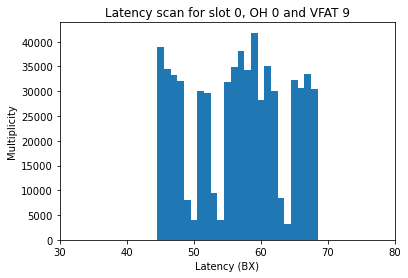

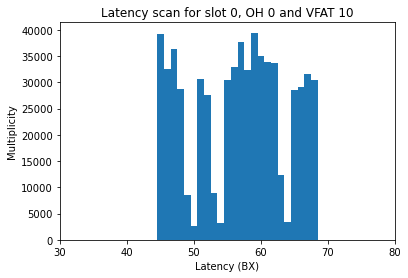

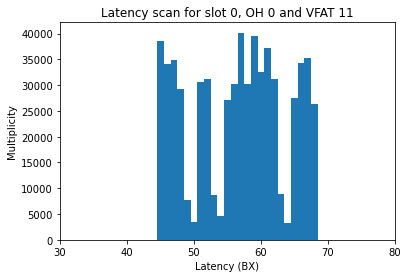

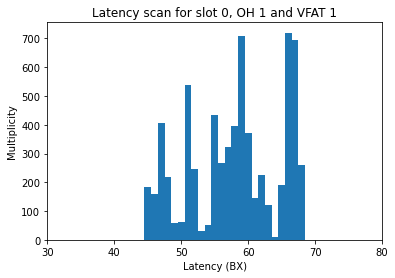

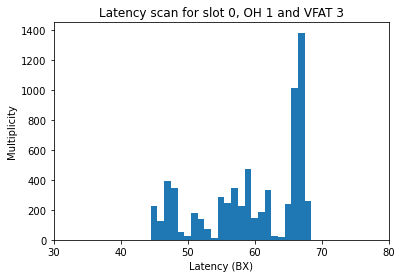

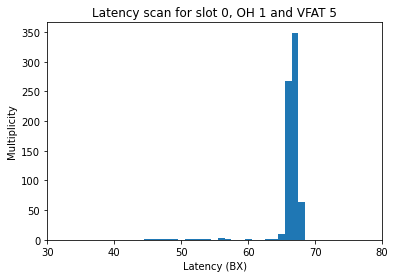

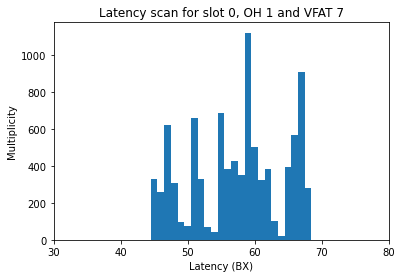

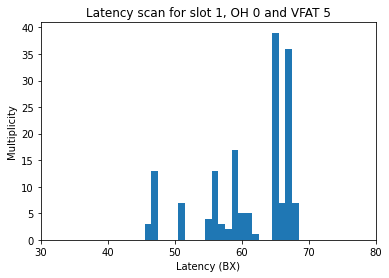

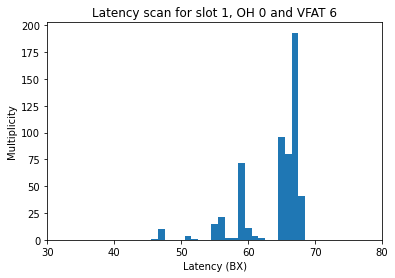

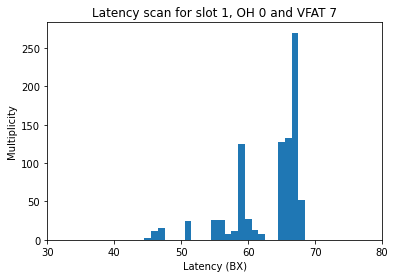

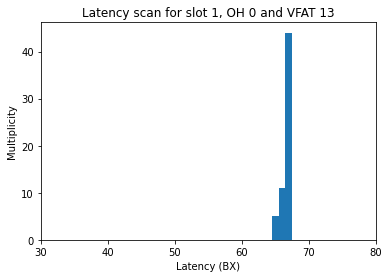

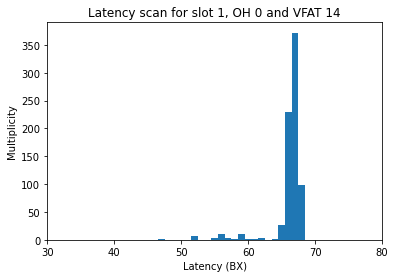

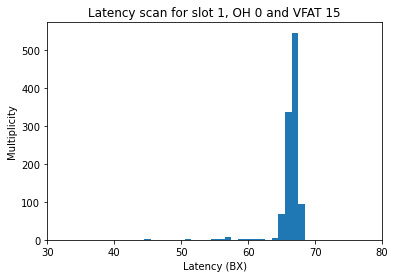

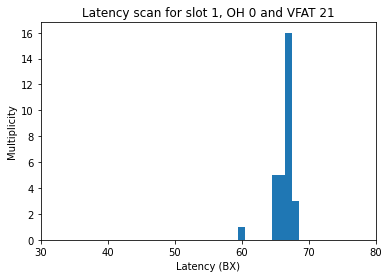

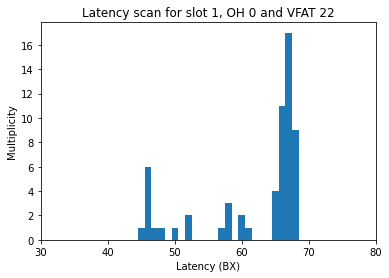

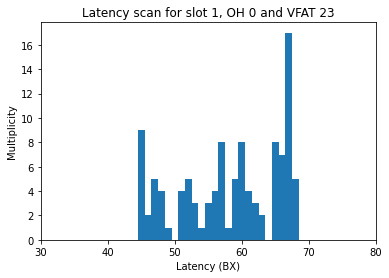

In [6]:
minbin=30
maxbin=80
binsize=1
bins=np.arange(minbin-0.5*binsize, maxbin+1.5*binsize, binsize)

# Loop over all slots. Slot 0 is ME0, slot 1 is GE2/1.
for slot in np.unique(ak.flatten(branches["slot"])):
    slot_mask = branches["slot"] == slot
    
    # Loop over all OH.
    for OH in np.unique(ak.flatten(branches["OH"][slot_mask])):
        OH_mask = branches["OH"] == OH
        
        for VFAT in np.unique(ak.flatten(branches["VFAT"][slot_mask & OH_mask])):
        # Loop over all VFATs.
            VFAT_mask = branches["VFAT"] == VFAT

            # Ak array that contains for every event the latency as many times as a strip fired (the multiplicity for this specific event).
            latencies = ak.broadcast_arrays(branches["digiStrip"], branches["runParameter"])[1]

            # Select the latency for the hits with given slot, OH and VFAT. 
            # The amount that a given latency is found is the multiplicity of the latency for a given VFAT.
            plt.hist(ak.flatten(latencies[slot_mask & OH_mask & VFAT_mask]), bins=bins)
            plt.xlim(minbin, maxbin)
            plt.xlabel("Latency (BX)")
            plt.ylabel("Multiplicity")
            plt.title(f"Latency scan for slot {slot}, OH {OH} and VFAT {VFAT}")
            plt.show()

Why there is not always a clear gaussian peak:
That probably means either that VFAT had too low threshold (if the total count is high) or it was outside of the beam (if total count is low), so in both case you are seeing only noise. These events have to be discarded, fitting gauss + background is not correct since it is cross talk and not background

Try fitting the peak with a gaussian and extracting a guess for the time resolution of the detector

In [7]:
def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

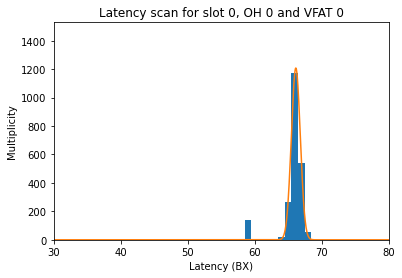

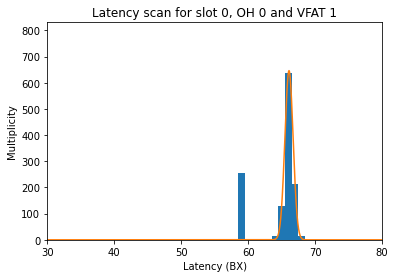

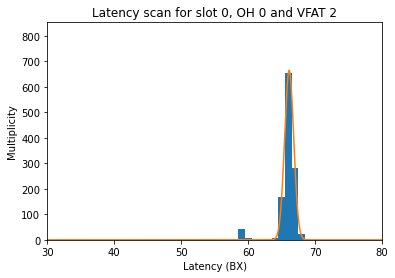

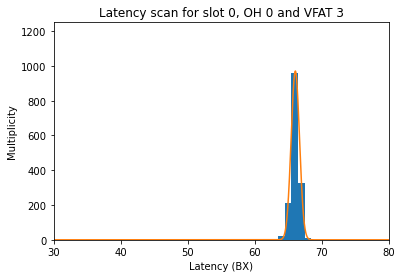

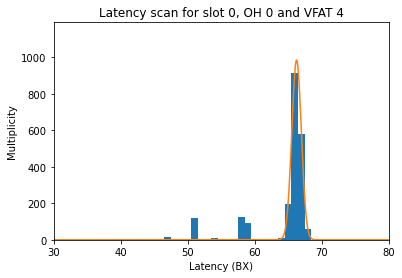

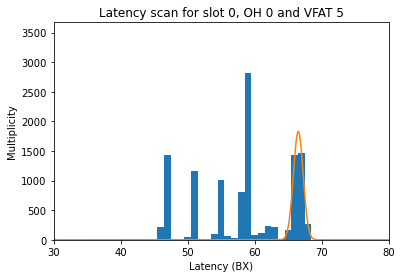

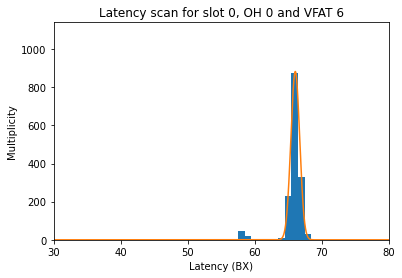

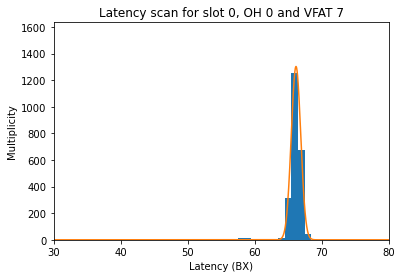

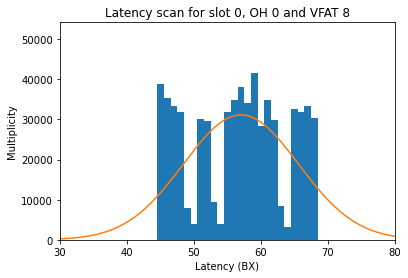

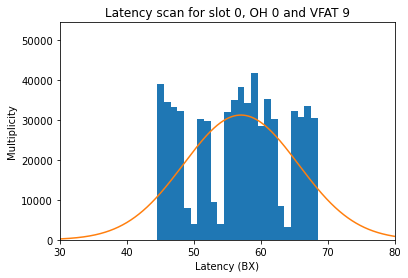

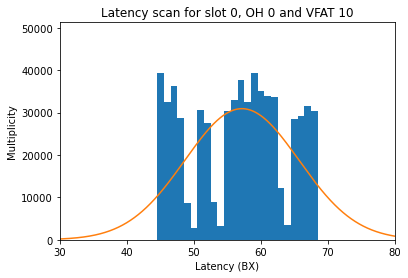

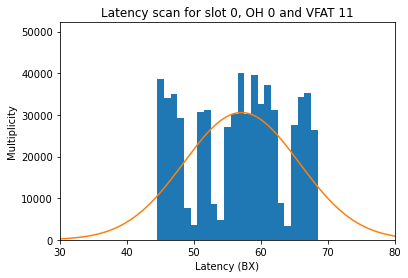

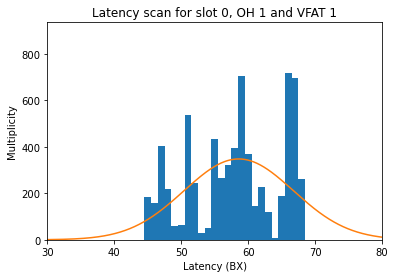

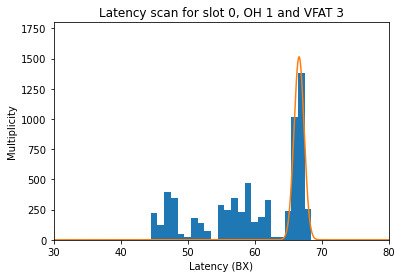

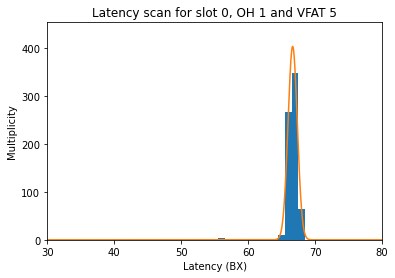

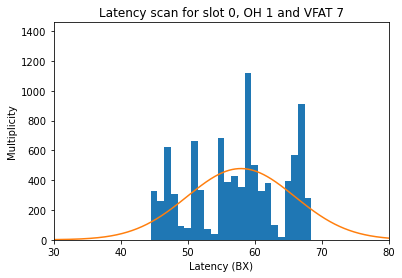

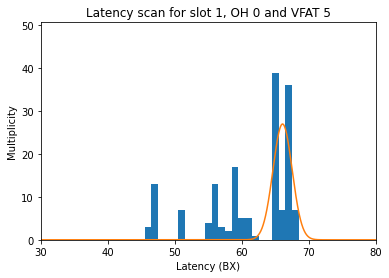

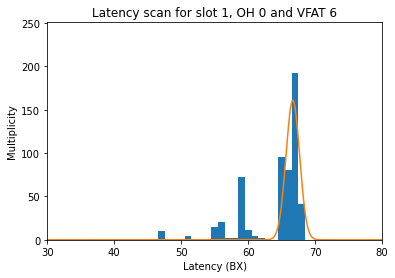

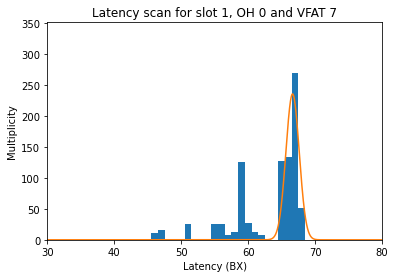

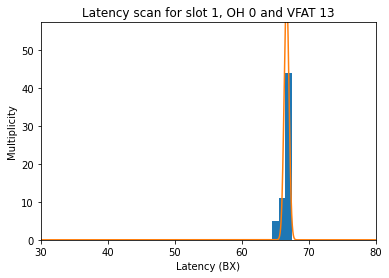

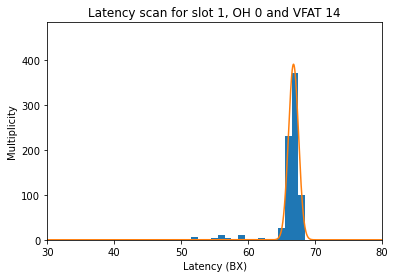

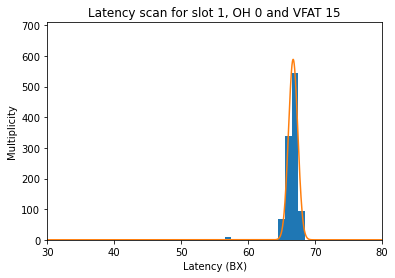

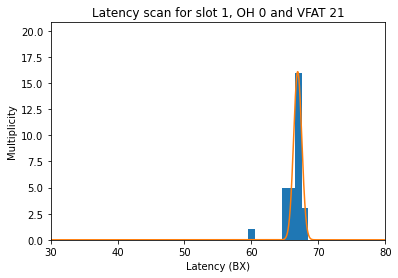

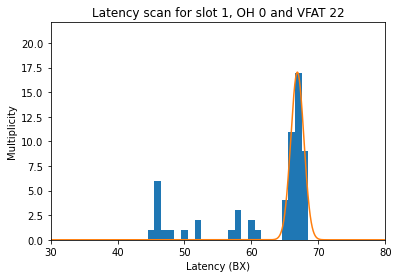

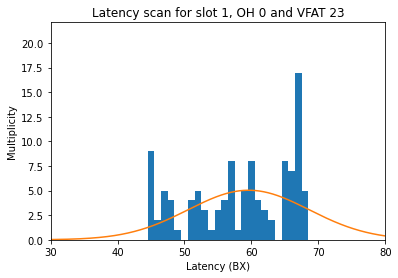

In [8]:
minbin=30
maxbin=80
binsize=1
bins=np.arange(minbin-0.5*binsize, maxbin+1.5*binsize, binsize)

# Loop over all slots. Slot 0 is ME0, slot 1 is GE2/1.
for slot in np.unique(ak.flatten(branches["slot"])):
    slot_mask = branches["slot"] == slot
    
    # Loop over all OH.
    for OH in np.unique(ak.flatten(branches["OH"][slot_mask])):
        OH_mask = branches["OH"] == OH
        
        for VFAT in np.unique(ak.flatten(branches["VFAT"][slot_mask & OH_mask])):
        # Loop over all VFATs.
            VFAT_mask = branches["VFAT"] == VFAT

            # Ak array that contains for every event the latency as many times as a strip fired (the multiplicity for this specific event).
            latencies = ak.broadcast_arrays(branches["digiStrip"], branches["runParameter"])[1]

            # Select the latency for the hits with given slot, OH and VFAT. 
            # The amount that a given latency is found is the multiplicity of the latency for a given VFAT.
            fitdata, fitbins, _ = plt.hist(ak.flatten(latencies[slot_mask & OH_mask & VFAT_mask]), bins=bins)
            bincenters = fitbins[:-1] + binsize / 2
            
            parameters, covariance = curve_fit(gaussian, bincenters, fitdata, p0=[1200, 65, 2])
            plt.plot(np.arange(minbin, maxbin, 0.001), gaussian(np.arange(minbin, maxbin, 0.001), *parameters), label=f"Gaussian with $\mu$ = {parameters[1]:.2f} and $\sigma$ = {parameters[2]:.2f}")

            plt.xlim(minbin, maxbin)
            plt.ylim(0, 1.3*np.max(fitdata))
            plt.xlabel("Latency (BX)")
            plt.ylabel("Multiplicity")
            plt.title(f"Latency scan for slot {slot}, OH {OH} and VFAT {VFAT}")
            #plt.legend(bbox_to_anchor=[1, 1], loc='upper right')
            plt.show()

Time resolution around 0.7 bunch crossings.

### Sanity check
If event count instead of multiplicity is used, do you recover similar numbers as example? => Exactly the same plot, so this is fine!

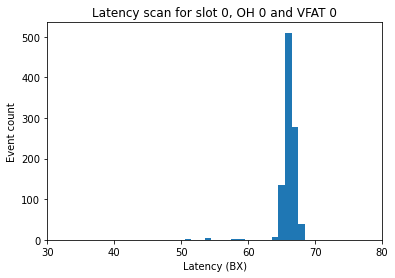

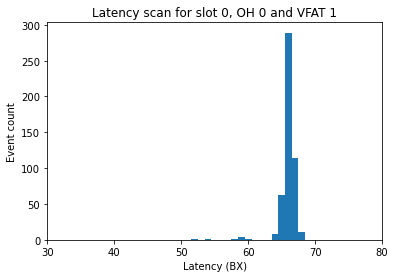

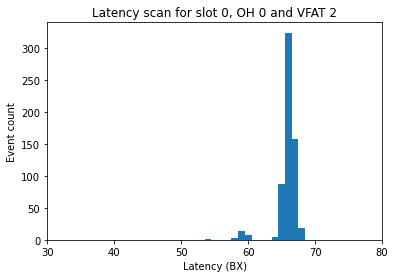

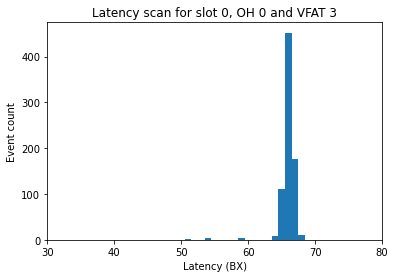

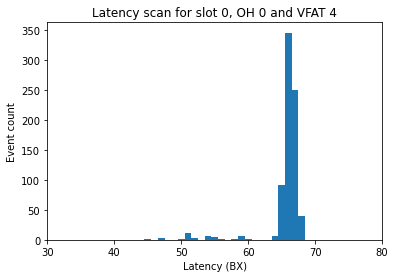

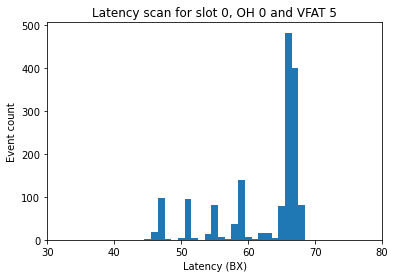

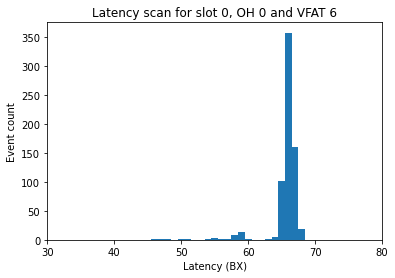

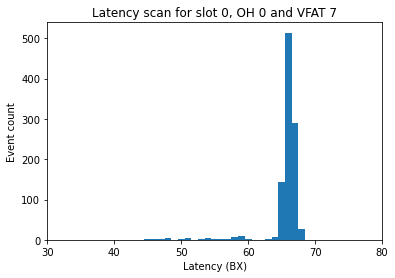

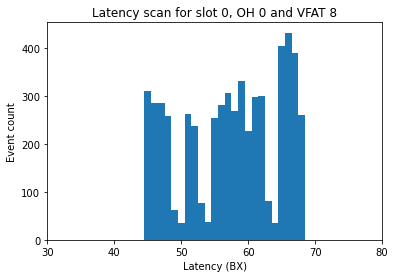

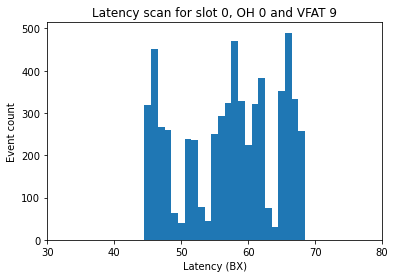

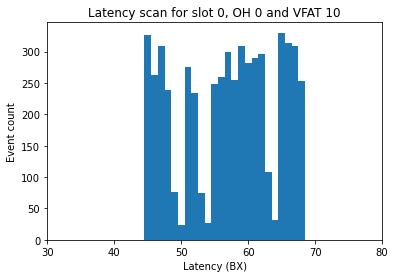

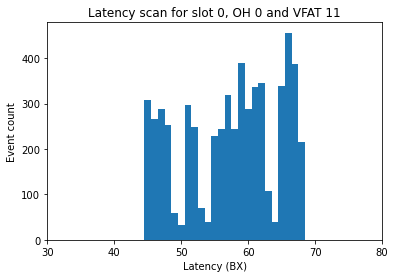

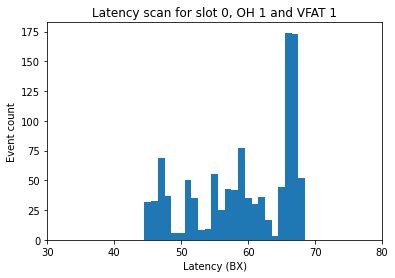

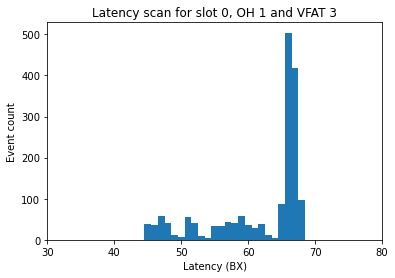

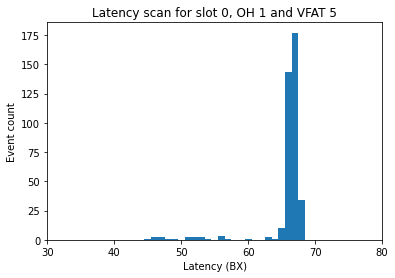

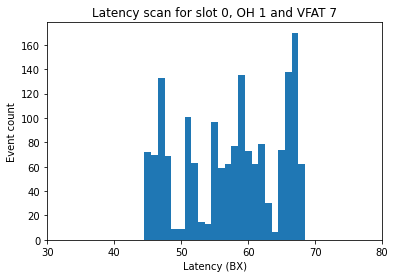

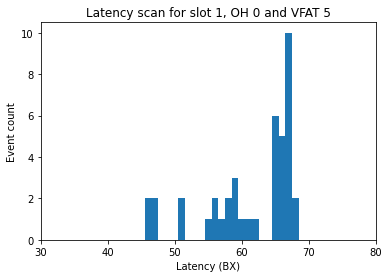

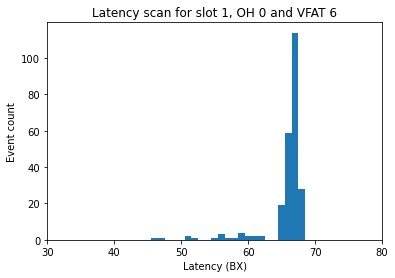

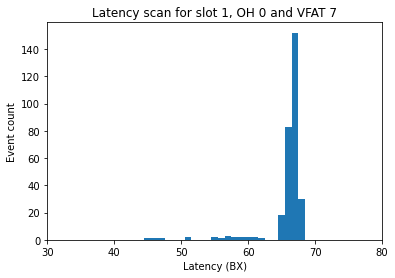

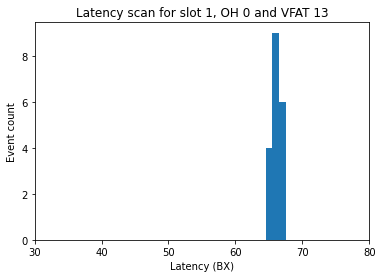

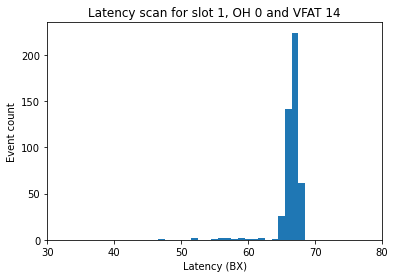

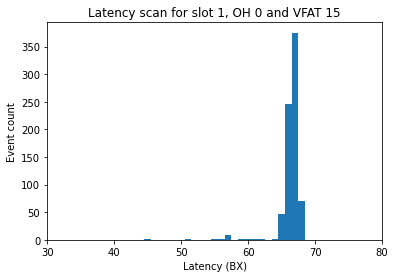

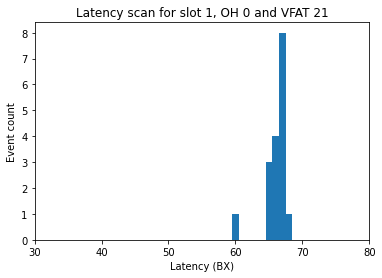

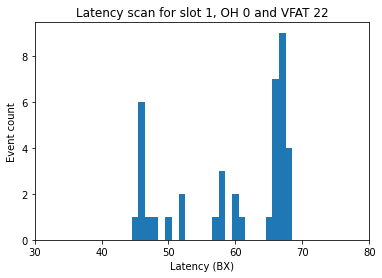

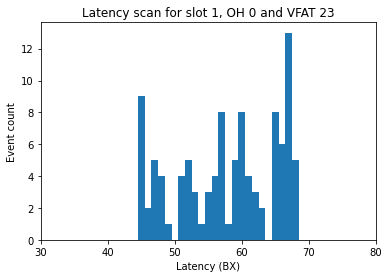

In [9]:
minbin=30
maxbin=80
binsize=1
bins=np.arange(minbin-0.5*binsize, maxbin+1.5*binsize, binsize)

# Loop over all slots. Slot 0 is ME0, slot 1 is GE2/1.
for slot in np.unique(ak.flatten(branches["slot"])):
    slot_mask = branches["slot"] == slot
    
    # Loop over all OH.
    for OH in np.unique(ak.flatten(branches["OH"][slot_mask])):
        OH_mask = branches["OH"] == OH
        
        for VFAT in np.unique(ak.flatten(branches["VFAT"][slot_mask & OH_mask])):
        # Loop over all VFATs.
            VFAT_mask = branches["VFAT"] == VFAT

            # Latency for each event
            latencies = branches["runParameter"]

            # Select the latency for the events with hits with given slot, OH and VFAT. 
            plt.hist(latencies[np.any(slot_mask & OH_mask & VFAT_mask, axis=1)], bins=bins)
            plt.xlim(minbin, maxbin)
            plt.xlabel("Latency (BX)")
            plt.ylabel("Event count")
            plt.title(f"Latency scan for slot {slot}, OH {OH} and VFAT {VFAT}")
            plt.show()